# Solutions to HW 3: BNN + BBVI

For the original HW3 Instructions from Fall 2019see:

https://www.cs.tufts.edu/comp/150BDL/2019f/hw3.html

# Clickable Table of Contents

* [Data Structure for BNN](#data-structures)
* [Data Structure for Approx Posterior Parameters for BNN](#approx-posterior-data-structures)
* [Function to sample from an approximate posterior](#sample-from-q)

#### Problem 1
* [Functions to calculate logpdf for likelihood, prior, and q](#define-logpdf-likelihood-prior-q)
* [Function to calculate VI loss via MC samples](#calc_vi_loss)
* [Function to calculate gradient of VI loss via MC samples and score function trick](#calc_grad_of_vi_loss)

#### Problem 2
* [Run BBVI Function](#run_bbvi)
* [Problem 2a](#problem-2a)
* [Problem 2b](#problem-2b)
* [Problem 2c](#problem-2c)
* [Problem 2d](#problem-2d)


# Import Statements

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import sklearn.metrics as skm

In [32]:
import autograd
import autograd.numpy as ag_np
import autograd.scipy.stats as ag_stats
ag_np.random.seed(42)

In [33]:
import scipy.io

In [34]:
import pickle
import copy
import time
import datetime

In [35]:
# Imports for multiprocessing
import concurrent.futures


#import multiprocessing as mp
#from multiprocessing.pool import ThreadPool
#import threading as thr

## Pull local datasets
Using only subj1 data at the moment

In [36]:
# EEG Data
x_train_N = scipy.io.loadmat('subj1_session1_xDataPower.mat')
x_train_N = ag_np.asarray(x_train_N['xData1power'])
y_train_N = scipy.io.loadmat('subj1_session1_yData.mat')
y_train_N = ag_np.asarray(y_train_N['yData1'])

# Toy data
#x_train_N = ag_np.asarray([[-5,5],[-4,4],[-3,3],[3,-3],[4,-4],[5,-5]])
#y_train_N = ag_np.concatenate([ag_np.zeros(3), ag_np.ones(3)])
#w = [5.0, 3.0]
#b = 20.0
#y_train_N = ag_np.dot(w, x_train_N.transpose())+b

# Data details
num_trials = x_train_N.shape[0]
num_feats = x_train_N.shape[1]

hit_inds = y_train_N==1
miss_inds = y_train_N==0
num_hits = ag_np.sum(hit_inds)
num_misses = ag_np.sum(miss_inds)
hit_rate = num_hits/num_trials
miss_rate = num_misses/num_trials
print('hit rate:  %0.2f' % hit_rate)
print('miss rate: %0.2f' % miss_rate)


print('\nnum_trials:',num_trials,'\nnum_feats:',num_feats)
#print('\nx\n',x_train_N,'\ny\n', y_train_N)

hit rate:  0.71
miss rate: 0.29

num_trials: 248 
num_feats: 336


# Configure options

In [37]:
DO_VERY_LONG_TRAINING_RUNS = True

In [38]:
if DO_VERY_LONG_TRAINING_RUNS:
    prefix_now_datestamp = datetime.datetime.today().strftime('%Y%m%dT%H%M')
    print("New results would be saved with datestamp %s" % (prefix_now_datestamp))

New results would be saved with datestamp 20191203T1803


In [39]:
if not DO_VERY_LONG_TRAINING_RUNS:
    prefix_toload_datestamp = '20191002T1213'

# Hyperparameters

In [40]:
n_hidden_layers = [ag_np.int(num_feats/2)]

prior_mean = 0.0
prior_stddev = 1.0

<a name="data-structures"></a>

# Data structure for BNN model parameters

Use a list of dicts called "bnn_param_list".

First entry contains weights + bias for first layer.
Second entry contains weights + bias for second layer.

In [41]:
def make_bnn_param_list(
        n_hiddens_per_layer_list=[5],
        n_dims_input=1,
        n_dims_output=1,
        weight_fill_func=lambda tuple:  ag_np.random.randn(*tuple),
        bias_fill_func=ag_np.zeros):
    bnn_param_list = []
    n_hiddens_per_layer_list = [n_dims_input] + n_hiddens_per_layer_list + [n_dims_output]
    for n_in, n_out in zip(n_hiddens_per_layer_list[:-1], n_hiddens_per_layer_list[1:]):
        bnn_param_list.append(
            dict(
                w=weight_fill_func((n_in, n_out)),
                b=bias_fill_func((n_out,)),
            ))
    return bnn_param_list

In [42]:
def pretty_print_bnn_param_list(bnn_param_list_of_dict):
    for ll, layer_dict in enumerate(bnn_param_list_of_dict):
        print("Layer %d" % ll)
        print("  w | size %9s | %s" % (layer_dict['w'].shape, layer_dict['w'].flatten()))
        print("  b | size %9s | %s" % (layer_dict['b'].shape, layer_dict['b'].flatten()))


In [43]:
def sigmoid(x):
#    return 1. / (1. + ag_np.exp(-x))
    return 0.5*(ag_np.tanh(x/2) + 1)

def predict_with_bnn(x=None, bnn_param_list=None, activation_func=ag_np.tanh, step=False):
    for layer_id, layer_dict in enumerate(bnn_param_list):
        if layer_id == 0:
            if x.ndim > 1:
                in_arr = x
            else:
                if x.size == bnn_param_list[0]['w'].shape[0]:
                    in_arr = x[ag_np.newaxis,:]
                else:
                    in_arr = x[:,ag_np.newaxis]                    
        else:
            in_arr = activation_func(out_arr)
        out_arr = ag_np.dot(in_arr, layer_dict['w']) + layer_dict['b']
    out_arr = sigmoid(ag_np.squeeze(out_arr))
    out_arr = ag_np.squeeze(out_arr)
    if step:
        out_arr = 1*(out_arr>0.5)
    if len(out_arr.shape)==1:
        out_arr = ag_np.reshape(out_arr, [out_arr.shape[0],1])
    return out_arr

#### Try it! Make a network with 0 hid layers

In [44]:
n_hidden_layers = []
print("#hidUnitsperLayer=%s\n#dimInput=%i"%(str(n_hidden_layers),num_feats))
my_bnn_param_list = make_bnn_param_list(
    n_hiddens_per_layer_list=n_hidden_layers, n_dims_input=num_feats, n_dims_output=1)
pretty_print_bnn_param_list(my_bnn_param_list)

#hidUnitsperLayer=[]
#dimInput=336
Layer 0
  w | size  (336, 1) | [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004 -0.46341769 -0.46572975
  0.24196227 -1.91328024 -1.72491783 -0.56228753 -1.01283112  0.31424733
 -0.90802408 -1.4123037   1.46564877 -0.2257763   0.0675282  -1.42474819
 -0.54438272  0.11092259 -1.15099358  0.37569802 -0.60063869 -0.29169375
 -0.60170661  1.85227818 -0.01349722 -1.05771093  0.82254491 -1.22084365
  0.2088636  -1.95967012 -1.32818605  0.19686124  0.73846658  0.17136828
 -0.11564828 -0.3011037  -1.47852199 -0.71984421 -0.46063877  1.05712223
  0.34361829 -1.76304016  0.32408397 -0.38508228 -0.676922    0.61167629
  1.03099952  0.93128012 -0.83921752 -0.30921238  0.33126343  0.97554513
 -0.47917424 -0.18565898 -1.10633497 -1.19620662  0.81252582  1.35624003
 -0.07201012  1.0035329   0.36163603 -0.64511975  0.36139561  1.53803657
 -0.03582604  1.56464366 -2.6197451   0.8219025   0.087047

#### Show network predictions for 10 trials of data

In [45]:
predict_with_bnn(x=x_train_N, bnn_param_list=my_bnn_param_list, step=True)

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
    

## Setup: Function for visualizing samples of f(x) from network

In [46]:
def plot_f_samples_at_x_grid(x_grid_G, f_grid_SG, color=None, ymin=-5, ymax=+5, axis_handle=None):
    if axis_handle is None:
        axis_handle = plt.gca()
    S, G = f_grid_SG.shape
    for s in range(S):
        axis_handle.plot(x_grid_G, f_grid_SG[s], color=color)
    axis_handle.set_ylim([ymin, ymax])

## Setup: Function for visualizing mean +/- stddev of f(x) from network

In [47]:
def plot_empirical_mean_with_filled_stddevs_for_f_samples_at_x_grid(
        x_grid_G, f_grid_SG, n_stddev_to_fill=2,
        color=None, ymin=-5, ymax=+5, axis_handle=None):

    if axis_handle is None:
        axis_handle = plt.gca()
    mean_G = ag_np.mean(f_grid_SG, axis=0)
    stddev_G = ag_np.std(f_grid_SG, axis=0)
    
    axis_handle.plot(x_grid_G, mean_G, color=color)
    axis_handle.fill_between(
        x_grid_G,
        mean_G - n_stddev_to_fill*stddev_G,
        mean_G + n_stddev_to_fill*stddev_G,
        alpha=0.3,
        facecolor=color)


## Setup: function to add together two param_list_of_dict objects

In [48]:
def add_param_list_of_dicts(A_param_list, B_param_list=None, B_scalar=None, inplace=True):
    if B_scalar is None:
        if B_param_list is None:
            B_scalar = 0.0 # by default, dont add anything
        else:
            B_scalar = 1.0 # default weight of second arg is 1.0
    
    if not inplace:
        # Create new list of dict of arrays to hold output of sum operation
        A_param_list = copy.deepcopy(A_param_list)
    start = 0
    for layer_id, layer_dict in enumerate(A_param_list):
        if B_param_list is None:
            for key, layer_arr in layer_dict.items():
                layer_arr[:] += B_scalar
        else:
            for key, layer_arr in layer_dict.items():
                layer_arr[:] += B_scalar * B_param_list[layer_id][key]

    return A_param_list

In [49]:
## Test it:
my_bnn_param_list = make_bnn_param_list(
    n_hiddens_per_layer_list=n_hidden_layers, n_dims_input=num_feats, n_dims_output=1)

print("BEFORE     params")
pretty_print_bnn_param_list(my_bnn_param_list)

print("\nAFTER  add params + 5.0")
ans_bnn_params = add_param_list_of_dicts(
    my_bnn_param_list, B_scalar=5.0, inplace=False)
pretty_print_bnn_param_list(ans_bnn_params)


print("\nAFTER  add params + params")
ans_bnn_params = add_param_list_of_dicts(
    my_bnn_param_list, copy.deepcopy(my_bnn_param_list), inplace=False)
pretty_print_bnn_param_list(ans_bnn_params)

print("\nAFTER  add params + 2.0 * params")
ans_bnn_params = add_param_list_of_dicts(
    my_bnn_param_list, copy.deepcopy(my_bnn_param_list), 2.0, inplace=False)
pretty_print_bnn_param_list(ans_bnn_params)



BEFORE     params
Layer 0
  w | size  (336, 1) | [-0.8254972  -0.32138584  0.41293145 -0.56372455 -0.8222204   0.24368721
  0.24496657 -0.50694318 -0.47103831  0.23204994 -1.44808434 -1.40746377
 -0.71844422 -0.21344715  0.31090757  1.47535622  0.85765962 -0.15993853
 -0.01901621 -1.00252936 -0.01851314 -0.28865864  0.32271856 -0.82723094
  0.51934651  1.53273891 -0.10876015  0.40171172  0.69014399 -0.40122047
  0.22409248  0.0125924   0.0976761  -0.77300978  0.02451017  0.49799829
  1.45114361  0.95927083  2.15318246 -0.76734756  0.87232064  0.18334201
  2.18980293 -0.80829829 -0.83972184 -0.59939265 -2.12389572 -0.52575502
 -0.75913266  0.15039379  0.34175598  1.87617084  0.95042384 -0.57690366
 -0.89841467  0.49191917 -1.32023321  1.83145877  1.17944012 -0.46917565
 -1.71313453  1.35387237 -0.11453985  1.23781631 -1.59442766 -0.59937502
  0.0052437   0.04698059 -0.45006547  0.62284993 -1.06762043 -0.14237949
  0.12029563  0.51443883  0.71161488 -1.12464209 -1.53411417  1.27767682
  

# Data Structure for Representing Params of Approximate Posterior q(w)

Again, use a list of dicts. Each layer has keys "w_mean", "w_log_stddev", "b_mean", "b_log_stddev"

In [50]:
def make_q_param_list(
        n_hiddens_per_layer_list=[5],
        n_dims_input=1,
        n_dims_output=1,
        mean_fill_func_name='randn',
        stddev_fill_func_name='ones',
        seed=101):
    prng = ag_np.random.RandomState(seed)
    try:
        getattr(prng, mean_fill_func_name)
        mean_fill_func = lambda size_tuple: getattr(prng, mean_fill_func_name)(*size_tuple)
    except Exception:
        mean_fill_func = getattr(ag_np, mean_fill_func_name)
    try:
        getattr(prng, stddev_fill_func_name)
        stddev_fill_func = lambda size_tuple: getattr(prng, stddev_fill_func_name)(*size_tuple)
    except Exception:
        stddev_fill_func = getattr(ag_np, stddev_fill_func_name)
        
    q_param_list = []
    n_hiddens_per_layer_list = [n_dims_input] + n_hiddens_per_layer_list + [n_dims_output]
    for n_in, n_out in zip(n_hiddens_per_layer_list[:-1], n_hiddens_per_layer_list[1:]):
        q_param_list.append(
            dict(
                w_mean=mean_fill_func((n_in, n_out)),
                w_log_stddev=ag_np.log(stddev_fill_func((n_in, n_out))),
                b_mean=mean_fill_func((n_out,)),
                b_log_stddev=ag_np.log(stddev_fill_func((n_out,))),
            ))
    return q_param_list

## Function to pretty print the parameters of approximate posterior

In [51]:
def pretty_print_q_param_list(q_param_list, show_log_stddev=False):
    for ll, layer_dict in enumerate(q_param_list):
        print("Layer %d" % ll)
        if show_log_stddev:
            print("  q(w) | size %9s | MEAN %s | LOG_STDDEV %s" % (
                layer_dict['w_mean'].shape,
                layer_dict['w_mean'].flatten(),
                layer_dict['w_log_stddev'].flatten(),
                ))
            print("  q(b) | size %9s | MEAN %s | LOG_STDDEV %s" % (
                layer_dict['b_mean'].shape,
                layer_dict['b_mean'].flatten(),
                layer_dict['b_log_stddev'].flatten(),        
                ))

        else:
            print("  q(w) | size %9s | MEAN %s | STDDEV %s" % (
                layer_dict['w_mean'].shape,
                layer_dict['w_mean'].flatten(),
                ag_np.exp(layer_dict['w_log_stddev'].flatten()),
                ))
            print("  q(b) | size %9s | MEAN %s | STDDEV %s" % (
                layer_dict['b_mean'].shape,
                layer_dict['b_mean'].flatten(),
                ag_np.exp(layer_dict['b_log_stddev'].flatten()),        
                ))


In [52]:
# Function to vectorize nn_param_list
def dict_to_vec(nn_params, keys=None):
    out_vec = []
    for ll, layer in enumerate(nn_params):
        if keys==None:
            layer_keys = list(layer.keys())
        else:
            layer_keys = keys
        for k in layer_keys:
            if k in layer.keys():
                kVals = layer[k].flatten()
                for val in kVals:
                    out_vec.append(val)
    return ag_np.asarray(out_vec)

def vec_to_dict(vec, nn_params):
    params_vec = copy.deepcopy(vec)
    params_vec = params_vec.tolist()
    out_params = copy.deepcopy(nn_params)
    for ll, layer in enumerate(out_params):
        layer_keys = list(layer.keys())
        for k in layer_keys:
            tempShape = out_params[ll][k].shape
            kRows = tempShape[0]
            for row in range(kRows):
                if len(tempShape)>1:
                    kCols = tempShape[1]
                    for col in range(kCols):
                        val = params_vec.pop(0)
                        out_params[ll][k][row][col] = val
                else:
                    val = params_vec.pop(0)
                    out_params[ll][k][row] = val
    return out_params

def vec_to_dict2(vec, nn_params):
    params_vec = copy.deepcopy(vec)
    params_vec = params_vec.tolist()
    out_params = copy.deepcopy(nn_params)
    for ll, layer in enumerate(out_params):
        layer_keys = list(layer.keys())
        for k in layer_keys:
            tempShape = out_params[ll][k].shape
            kRows = tempShape[0]
            for row in range(kRows):
                if len(tempShape)>1:
                    kCols = tempShape[1]
                    out_params[ll][k][row][0:kCols] = params_vec[-kCols:]
                    params_vec = params_vec[:-kCols]
                else:
                    val = params_vec.pop(0)
                    out_params[ll][k][row] = val
    return out_params

## Function to generate epsilon ~N(0,I) of size q_params

In [53]:
def sample_epsilon(q_params, prng=ag_np.random):
    epsilon = list()
    for layer in q_params:
        w_size = layer['w_mean'].shape
        b_size = layer['b_mean'].shape
        w = prng.randn(*w_size)
        b = prng.randn(*b_size)
        epsilon.append(dict(w=w, b=b))
    return epsilon

## Function to sample bnn parameters given an approximate posterior

In [54]:
def sample_bnn_params_from_q(q_param_list_of_dict, prng=ag_np.random, n_samples=1, epsilon=None):
    """ Sample values of weights/biases given approx. posterior defined by q_param_dict """
    bnn_samples = list()
    for sample_id in range(n_samples):
        cur_bnn_params = list()
        for ll, q_layer_dict in enumerate(q_param_list_of_dict):
            w_size = q_layer_dict['w_mean'].shape
            b_size = q_layer_dict['b_mean'].shape
            if type(epsilon) == type(None):
                w = ag_np.exp(q_layer_dict['w_log_stddev']) * prng.randn(*w_size) + q_layer_dict['w_mean']
                b = ag_np.exp(q_layer_dict['b_log_stddev']) * prng.randn(*b_size) + q_layer_dict['b_mean']
            else:
                w = ag_np.exp(q_layer_dict['w_log_stddev']) * epsilon[ll]['w'] + q_layer_dict['w_mean']
                b = ag_np.exp(q_layer_dict['b_log_stddev']) * epsilon[ll]['b'] + q_layer_dict['b_mean']
            cur_bnn_params.append(dict(w=w, b=b))
        bnn_samples.append(cur_bnn_params)
    return bnn_samples

In [55]:
init_q_params = make_q_param_list(
            n_hiddens_per_layer_list=[],
            n_dims_input = num_feats,
            n_dims_output = 1,
            mean_fill_func_name='randn',
            stddev_fill_func_name='ones',
            seed=1000)

print('Q Params')
pretty_print_q_param_list(init_q_params)

Q Params
Layer 0
  q(w) | size  (336, 1) | MEAN [-8.04458304e-01  3.20931547e-01 -2.54828805e-02  6.44323828e-01
 -3.00796673e-01  3.89474554e-01 -1.07437302e-01 -4.79983075e-01
  5.95035502e-01 -4.64667526e-01  6.67281307e-01 -8.06115610e-01
 -1.19606983e+00 -4.05960161e-01 -1.82377340e-01  1.03192894e-01
 -1.38421989e-01  7.05692375e-01  1.27179528e+00 -9.86747329e-01
 -3.34835453e-01 -9.94816980e-02  4.07192100e-01  9.19387539e-01
  3.12118010e-01  1.53316107e+00 -5.50173865e-01 -3.83147411e-01
 -8.22940963e-01  1.60008337e+00 -6.92812989e-02  8.32094921e-02
 -3.26924675e-01 -4.57971880e-02 -3.04460062e-01  1.92301013e+00
 -7.86590035e-02 -5.82065723e-01 -1.61798224e+00  8.67260817e-01
 -1.04043709e+00  6.50421425e-01  2.69964586e+00  8.02024514e-01
 -1.09692126e+00 -1.78054446e-01 -4.22870478e-01 -3.30400548e-01
 -1.11116278e+00 -7.42005751e-01  2.57475919e+00  1.07321332e+00
 -1.86613451e+00 -6.47176927e-01  1.08224081e+00  1.76670316e-01
 -8.35328233e-01 -1.69499832e+00  1.133417

In [56]:
epsilon = sample_epsilon(init_q_params)
print('Epsilon')
pretty_print_bnn_param_list(epsilon)

Epsilon
Layer 0
  w | size  (336, 1) | [-0.34268759 -0.37144087 -1.40751169 -0.77781669 -1.11057585  1.75227044
  0.93567839  1.27155509  0.72167206 -1.12905177 -0.52452027  0.48937456
 -1.22212781  0.71299843 -0.2403254  -0.37482081  0.71095997  0.44426331
 -0.36096617  1.1593298  -1.08106333  0.61593561  0.59310126 -0.30954644
  0.32613302 -1.25111358  0.92402702 -0.18490214 -0.52272302  1.04900923
 -0.70434369 -1.4084613  -1.55662917  0.60600995 -1.28042935  1.75479418
 -2.08192941  1.69645637  0.21101747 -0.09671311 -0.54491909  0.39913611
 -0.0376347   1.10330188  0.11422765  0.15030176 -0.36361221 -0.05694562
  0.30780177 -1.71016839 -1.34818542  0.74326409  0.17086544 -0.18398334
  0.01843393  0.34758171 -0.53975968 -0.77830473  0.19584526 -0.97837278
  0.40825276 -1.7025836   1.02915564  0.47259748  0.25602973  0.98269098
  1.66547444  1.01437007 -1.84087423 -1.27957697 -0.62481858  0.02609105
  0.51765902 -0.72574381  0.18676676 -0.75538293 -0.6115178  -1.4066611
 -0.92323325 

In [57]:
# Test it
bnn_samples = sample_bnn_params_from_q(init_q_params, n_samples=1, epsilon=epsilon)
for bnn_sample in bnn_samples:
    pretty_print_bnn_param_list(bnn_sample)
    print("")

Layer 0
  w | size  (336, 1) | [-1.14714590e+00 -5.05093189e-02 -1.43299458e+00 -1.33492859e-01
 -1.41137252e+00  2.14174500e+00  8.28241091e-01  7.91572020e-01
  1.31670757e+00 -1.59371930e+00  1.42761041e-01 -3.16741049e-01
 -2.41819764e+00  3.07038269e-01 -4.22702739e-01 -2.71627914e-01
  5.72537980e-01  1.14995569e+00  9.10829111e-01  1.72582475e-01
 -1.41589878e+00  5.16453909e-01  1.00029336e+00  6.09841100e-01
  6.38251032e-01  2.82047489e-01  3.73853154e-01 -5.68049547e-01
 -1.34566398e+00  2.64909259e+00 -7.73624989e-01 -1.32525180e+00
 -1.88355385e+00  5.60212763e-01 -1.58488941e+00  3.67780431e+00
 -2.16058841e+00  1.11439065e+00 -1.40696477e+00  7.70547705e-01
 -1.58535617e+00  1.04955754e+00  2.66201115e+00  1.90532640e+00
 -9.82693609e-01 -2.77526848e-02 -7.86482690e-01 -3.87346171e-01
 -8.03361009e-01 -2.45217414e+00  1.22657377e+00  1.81647742e+00
 -1.69526907e+00 -8.31160263e-01  1.10067474e+00  5.24252021e-01
 -1.37508791e+00 -2.47330304e+00  1.32926249e+00  7.0157945

## Function to clip gradient

In [58]:
def clip_grad(grad_params, dict_keys_to_clip=None, min_value=None, max_value=None):
    out_params = copy.deepcopy(grad_params)
    if dict_keys_to_clip==None:
        dict_keys_to_clip = out_params[0].keys()
    for ll, layer in enumerate(out_params):
        for key in dict_keys_to_clip:
            temp_vals = layer[key][:]
            to_replace = temp_vals > max_value
            out_params[ll][key][to_replace] = max_value
            to_replace = temp_vals < min_value
            out_params[ll][key][to_replace] = min_value
    return out_params

## Function to calculate elbo AND gradient of elbo wrt q (reparam trick)

In [59]:
def calc_elbo_and_grad_elbo(q_params, epsilon, return_elbo=True):
    
    def calc_likelihood_logpdf(q_list_of_dict):
        """ Compute logpdf of Bernoulli likelihood of predictions from bnn"""
        bnn_samples = sample_bnn_params_from_q(q_list_of_dict, n_samples=1, epsilon=epsilon)
        bnn_sample = bnn_samples[0]
        yhat_N = predict_with_bnn(bnn_param_list=bnn_sample, x=x_train_N)
        assert yhat_N.size == num_trials
        log_lik = ag_np.sum(y_train_N*ag_np.log(yhat_N+1e-30) + (1.0-y_train_N)*ag_np.log(1.0-yhat_N+1e-30))
#        print("log_lik",log_lik)

#        print('\n',skm.confusion_matrix(y_train_N, 1*(yhat_N>0.5), labels=[1,0]))
        return log_lik

    def calc_prior_logpdf(q_list_of_dict):
        """ Compute logpdf of prior """
        bnn_samples = sample_bnn_params_from_q(q_list_of_dict, n_samples=1, epsilon=epsilon)
        bnn_sample = bnn_samples[0]
        log_prior = 0.0
        for layer_id, bnn_layer_dict in enumerate(bnn_sample):
            logpdf_w = ag_np.sum(ag_stats.norm.logpdf(bnn_layer_dict['w'], prior_mean, prior_stddev))
            logpdf_b = ag_np.sum(ag_stats.norm.logpdf(bnn_layer_dict['b'], prior_mean, prior_stddev))
            log_prior += logpdf_w + logpdf_b
        return log_prior

    def calc_q_logpdf(q_list_of_dict):
        """ Compute logpdf of approx posterior: log q(bnn_weights | var params) """
        bnn_samples = sample_bnn_params_from_q(q_list_of_dict, n_samples=1, epsilon=epsilon)
        bnn_sample = bnn_samples[0]
        log_q = 0.0
        for layer_id, q_layer_dict in enumerate(q_list_of_dict):
            logpdf_w = ag_np.sum(
                ag_stats.norm.logpdf(
                    bnn_sample[layer_id]['w'], q_layer_dict['w_mean'], ag_np.exp(q_layer_dict['w_log_stddev'])))
            logpdf_b = ag_np.sum(
                ag_stats.norm.logpdf(
                    bnn_sample[layer_id]['b'], q_layer_dict['b_mean'], ag_np.exp(q_layer_dict['b_log_stddev'])))
            log_q += logpdf_w + logpdf_b
        return log_q
    
    def calc_elbo(q_params):
        log_lik = calc_likelihood_logpdf(q_params)
        log_prior = calc_prior_logpdf(q_params)
        log_q = calc_q_logpdf(q_params)
#        print(log_lik)
#        print(log_prior)
#        print(log_q)
        elbo = log_lik #+ log_prior - log_q
        return elbo

    grad_elbo_func = autograd.grad(calc_elbo)
    grad_elbo = grad_elbo_func(q_params)
    if return_elbo:
        return calc_elbo(q_params), grad_elbo
    return grad_elbo

In [60]:
# Test it
epsilon = sample_epsilon(init_q_params)
temp_grad_elbo = calc_elbo_and_grad_elbo(init_q_params, epsilon, return_elbo=False)

print('\n')
epsilon = sample_epsilon(init_q_params)
temp_grad_elbo = calc_elbo_and_grad_elbo(init_q_params, epsilon, return_elbo=False)

In [61]:
#args = (init_q_params, epsilon, False)
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    temp_grads = [executor.submit(lambda f: calc_elbo_and_grad_elbo(*a), args) for _ in range(1)]


In [62]:
#temp_grads

In [63]:
# NOTE: the code below is used just for debugging purposes
# NaNs were originally being generated from the grad calculation, but this was 
# found to be due to the sigmoid function and has since been updated
# No further NaNs should be found.
def watchForNan(numSamples=1):
    sampleList = dict(wmax=[], wmin=[], b=[], gradHasNan=[], modGradHasNan=[])
    for i in range(numSamples):
        epsilon = sample_epsilon(init_q_params)

        #print('orig epsilon')
        sampleList['wmax'].append(ag_np.min(dict_to_vec(epsilon,['w'])))
        sampleList['wmin'].append(ag_np.max(dict_to_vec(epsilon,['w'])))
        sampleList['b'].append(ag_np.max(dict_to_vec(epsilon,['b'])))
        #print('w\n',ag_np.min(dict_to_vec(epsilon,['w'])),ag_np.max(dict_to_vec(epsilon,['w'])))
        #print('b\n',ag_np.min(dict_to_vec(epsilon,['b'])),ag_np.max(dict_to_vec(epsilon,['b'])))
        temp_elbo, temp_grad_elbo = calc_elbo_and_grad_elbo(init_q_params, epsilon)
        sampleList['gradHasNan'].append(ag_np.isnan(dict_to_vec(temp_grad_elbo)).any())
        #print('\nHas nan:',ag_np.isnan(dict_to_vec(temp_grad_elbo)).any())

        mod_epsilon = clip_grad(epsilon, ['w'], -1., 1.)
        mod_epsilon = clip_grad(mod_epsilon, ['b'], -1., 1.)
        #print('\nmod epsilon')
        #print('w\n',ag_np.min(dict_to_vec(mod_epsilon,['w'])),ag_np.max(dict_to_vec(mod_epsilon,['w'])))
        #print('b\n',ag_np.min(dict_to_vec(mod_epsilon,['b'])),ag_np.max(dict_to_vec(mod_epsilon,['b'])))
        temp_elbo, temp_grad_elbo = calc_elbo_and_grad_elbo(init_q_params, mod_epsilon)
        sampleList['modGradHasNan'].append(ag_np.isnan(dict_to_vec(temp_grad_elbo)).any())
        #print('\nHas nan:',ag_np.isnan(dict_to_vec(temp_grad_elbo)).any())
    return sampleList

In [64]:
sampleList = watchForNan(100)
for i in range(len(sampleList['wmax'])):
    if sampleList['gradHasNan'][i] or sampleList['modGradHasNan'][i]:
        print('%0.2f, %0.2f, %0.2f,\t%s, %s' % (sampleList['wmax'][i], sampleList['wmin'][i], sampleList['b'][i], sampleList['gradHasNan'][i], sampleList['modGradHasNan'][i]))
    

/Users/saberbf/opt/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/Users/saberbf/opt/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


## Compute gradient of ELBO via reparameterization trick

In [65]:
def calc_grad_of_elbo_using_reparam_trick(
        q_list_of_dict,
        x_train_N=None, y_train_N=None,
        prior_mean=0.0, prior_stddev=1.0,
        n_mc_samples=10,
        grad_clip_abs_max=None,
        prng=ag_np.random,
        return_grad_and_loss=False):
    
    # Allocate all-zero array for average of gradient
    mean_grad__list_of_dict = copy.deepcopy(q_list_of_dict)
    for layer_dict in mean_grad__list_of_dict:
        for layer_arr in layer_dict.values():
            layer_arr[:] = 0.0
    
    # Use while-loop to MC sample grad of ELBO because some samples may return nan
    # so these are rejected and new samples drawn until valid
    sample_elbo = ag_np.zeros(n_mc_samples)
    sample_count = 0
    sample_id = 0
    while (sample_id < n_mc_samples):
        #print(sample_id)
        epsilon = sample_epsilon(q_list_of_dict, prng)
        temp_elbo, grad_of_elbo__list_of_dict = calc_elbo_and_grad_elbo(q_list_of_dict, epsilon)
        # if grad doesn't result in NaN then add to list
        entries = dict_to_vec(grad_of_elbo__list_of_dict)
        #print(firstEntry)
        if not ag_np.isnan(entries).any() and not ag_np.isinf(entries).any():
            sample_elbo[sample_id] = temp_elbo
            mean_grad__list_of_dict = add_param_list_of_dicts(
                mean_grad__list_of_dict,
                grad_of_elbo__list_of_dict,
                B_scalar=1.0 / float(n_mc_samples),
                inplace=False)
            sample_id += 1
        sample_count += 1
#    print('Needed %i samples' % sample_count)
    
    # Clip mean gradient if turned on
    if not grad_clip_abs_max==None:
        mean_grad__list_of_dict = clip_grad(grad_params=mean_grad__list_of_dict,
                                            min_value=-grad_clip_abs_max, max_value=grad_clip_abs_max)
        
    if return_grad_and_loss:
        elbo = ag_np.mean(sample_elbo)
        return mean_grad__list_of_dict, elbo
    else:
        return mean_grad__list_of_dict

In [81]:
# Test it
temp_grad_elbo, temp_elbo = calc_grad_of_elbo_using_reparam_trick(
        init_q_params,
        x_train_N, y_train_N,
        prior_mean=0.0, prior_stddev=1.0,
        n_mc_samples=300,
        grad_clip_abs_max=1e1,
        prng=ag_np.random,
        return_grad_and_loss=True)

# Test it
# print('\ninit q params')
# pretty_print_q_param_list(init_q_params, show_log_stddev=True)

# print('\nMC sample average gradient of elbo wrt q')
# pretty_print_q_param_list(temp_grad_elbo, show_log_stddev=True)

/Users/saberbf/opt/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:90: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
/Users/saberbf/opt/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


In [86]:
# temp_grad_elbo_Masked=copy.deepcopy(temp_grad_elbo)
# temp_grad_elbo_Masked[0]["w_mean"]  = 0*temp_grad_elbo_Masked[0]["w_mean"]
# temp_grad_elbo_Masked[0]["w_log_stddev"]  = 0*temp_grad_elbo_Masked[0]["w_log_stddev"]
# print(temp_grad_elbo_Masked[0])

## Run BBVI Main Function (reparam trick) (for an end user)

In [83]:
def run_bbvi_many_iters(
        init_q_params=None,
        x_train_N=None,
        y_train_N=None,
        prior_mean=0.0,
        prior_stddev=1.0,
        n_iters=100,
        step_size=0.001,
        n_mc_samples=100,
        grad_clip_abs_max=None,
        zero_grad_keys=[],
        chain_id=0,
        txt_log_file=None,
        prng=ag_np.random):

    if txt_log_file is not None:
        with open(txt_log_file, 'w') as f:
            f.write("")
    
    cur_q_params = copy.deepcopy(init_q_params)
    history = dict(
        iter=list(),
        grad_L1_norm=list(),
        loss=list(),
        w_00_mean=list(),
        w_00_log_stddev=list(),
        b_00_mean=list())
    
    start_time = time.time()
    for iter_id in range(n_iters):
        # Calc grad ELBO and ELBO
        grad_wrt_q_params, prev_loss = calc_grad_of_elbo_using_reparam_trick(
            cur_q_params, x_train_N, y_train_N, prior_mean, prior_stddev,
            n_mc_samples=n_mc_samples, grad_clip_abs_max=grad_clip_abs_max, prng=prng, return_grad_and_loss=True)
        
        # To test the BBVI function with just bias updates (w updates are masked)
#         grad_wrt_q_params_copy=copy.deepcopy(grad_wrt_q_params)
#         grad_wrt_q_params[0]["w_mean"]  = 0.*grad_wrt_q_params[0]["w_mean"]
#         grad_wrt_q_params[0]["w_log_stddev"]  = 0.*grad_wrt_q_params[0]["w_log_stddev"]
#         print(temp_grad_elbo_Masked[0])
        
        
        for key in zero_grad_keys:
            for layer_dict in grad_wrt_q_params:
                layer_dict[key][:] = 0.0
                            
        grad_L1_norm = 0.0
        n_dims = 0
        for layer in grad_wrt_q_params:
            for key, arr in layer.items():
                if key in zero_grad_keys:
                    continue
                n_dims += arr.size
                grad_L1_norm += ag_np.sum(ag_np.abs(arr))
        grad_L1_norm = grad_L1_norm / float(n_dims)
        
        history['iter'].append(iter_id)
        history['loss'].append(prev_loss)
        history['grad_L1_norm'].append(grad_L1_norm)
        history['w_00_mean'].append(cur_q_params[-1]['w_mean'][0,0])
        history['w_00_log_stddev'].append(cur_q_params[-1]['w_log_stddev'][0,0])
        history['b_00_mean'].append(cur_q_params[-1]['b_mean'][0])
        
        messages = 'on'
        if iter_id < 30 or ((iter_id+1) % 10 == 0) or iter_id == n_iters - 1:
            msg1 = "chain %02d | iter %6d/%d after %9.1f sec | loss %.6e | grad_L1_norm %.4e" % (
                chain_id, iter_id+1, n_iters, time.time() - start_time, prev_loss, grad_L1_norm)
            msg2 = "    w_mean % 8.2f  grad_w_mean % 8.2f  w_stddev % 8.2g  grad_w_log_stddev % 8.2f" % (
                cur_q_params[-1]['w_mean'][0,0],
                grad_wrt_q_params[-1]['w_mean'][0,0],
                ag_np.exp(cur_q_params[-1]['w_log_stddev'][0,0]),
                grad_wrt_q_params[-1]['w_log_stddev'][0,0])
            msg3 = "    b_mean % 8.2f  grad_b_mean % 8.2f  b_stddev % 8.2g  grad_b_log_stddev % 8.2f" % (
                cur_q_params[-1]['b_mean'][0],
                grad_wrt_q_params[-1]['b_mean'][0],
                ag_np.exp(cur_q_params[-1]['b_log_stddev'][0]),
                grad_wrt_q_params[-1]['b_log_stddev'][0])
            if messages == 'on':
                print(msg1)
                print(msg2)
                print(msg3,'\n')
            if txt_log_file is not None:
                with open(txt_log_file, 'a') as f:
                    f.write("%s\n" % msg1)
                    f.write("%s\n" % msg2)
        
        # Update parameters to go uphill!
#        dyn_step_size = grad_clip_abs_max/ag_np.max(ag_np.abs(dict_to_vec(grad_wrt_q_params)))*step_size
        dyn_step_size = step_size
        cur_q_params = add_param_list_of_dicts(cur_q_params, grad_wrt_q_params, dyn_step_size, inplace=False)

    print("")
    return cur_q_params, history

# Training with BBVI Multiple Runs

This section is pretty expensive (requires a few hours!)

Will run 5 separate chains (initializations), each one for a whopping 5000 iterations.

#### VERY LONG TRAINING RUNS (set binary flag at top of this notebook if you want this to run)

In [84]:
if not DO_VERY_LONG_TRAINING_RUNS:
    # Load preexisting .pkl file (so we can make result plots easily and not run expensive training all over again)
    prefix = 'HW3_P2_' + prefix_toload_datestamp
    print("SKIPPING TRAINING, USING SAVED RUNS in .pkl file: %s" % prefix)

    with open('%s_results_10hidden_learnAll.pkl' % prefix, 'rb') as fb:
        all_info = pickle.load(fb)

    info_by_chain = all_info['info_by_chain']
    q_params_by_chain = all_info['q_params_by_chain']
    n_chains = len(info_by_chain)
    n_bbvi_iters_per_chain = len(info_by_chain[0]['iter'])
    
else:

    # Save prefix for .pkl file (so we can make result plots easily from data on disk)
    prefix = 'HW3_P2_' + prefix_now_datestamp

    # Number of random inits and iters per init
    n_chains = 1
    n_bbvi_iters_per_chain = 300

    n_mc_samples = 100
    step_size = 1e-5
    grad_clip_abs_max = 1e3

    q_params_by_chain = list()
    info_by_chain = list()

    for chain_id in range(n_chains):

        random_seed = 100 + chain_id

        # Initialize some new random q_params
        prng = ag_np.random.RandomState(int(random_seed))
        init_q_params = make_q_param_list(
            n_hiddens_per_layer_list = n_hidden_layers,
            n_dims_input = num_feats,
            n_dims_output=1,
            mean_fill_func_name='randn',
            stddev_fill_func_name='ones',
            seed=10 + chain_id,
            )
        
        # Load previously ran optimal q params
        #prefix = 'working_model_mc100_lr1e-7_clip1e5'
        #load_info = pickle.load(open('%s_results_0hidden_learnAll.pkl' % prefix, 'rb'))
        #info_by_chain = load_info['info_by_chain']
        #init_q_params = load_info['q_params_by_chain'][-1]
        #init_q_params = opt_q_params

        # Run BBVI from that init
        opt_q_params, info = run_bbvi_many_iters(
            init_q_params = init_q_params,
            x_train_N = x_train_N, y_train_N=y_train_N,
            prior_mean = prior_mean, prior_stddev=prior_stddev,
            n_iters = n_bbvi_iters_per_chain,
            n_mc_samples = n_mc_samples,
            grad_clip_abs_max=grad_clip_abs_max,
            step_size = step_size,
            chain_id = chain_id,
            txt_log_file = '%s_log_chain%02d.txt' % (prefix, chain_id),
            prng = prng)

        # Store info for this chain
        info_by_chain.append(info)
        q_params_by_chain.append(opt_q_params)

        # Write output to disk (after each chain)
        all_chain_info = dict(info_by_chain=info_by_chain, q_params_by_chain=q_params_by_chain)
        with open('%s_results_0hidden_learnAll.pkl' % prefix, 'wb') as fb:
            pickle.dump(all_chain_info, fb)


{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

{'w_mean': array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 

In [88]:
load_info = pickle.load(open('%s_results_0hidden_learnAll.pkl' % 'HW3_P2_20191203T1803', 'rb'))
info_by_chain = load_info['info_by_chain']
q_params_by_chain = load_info['q_params_by_chain']

DOR mean: -58.89546945513274

Mean: 0.62
95% CI: 0.33, 0.91


Text(0.5, 1.0, 'Histogram of DOR for 2000 samples from optimal q parameters')

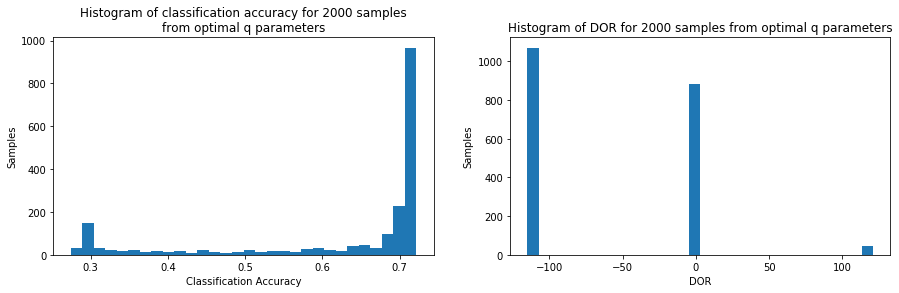

In [89]:
n_samples = 2000
bnn_samples = sample_bnn_params_from_q(opt_q_params, n_samples=n_samples)
class_acc = ag_np.zeros(n_samples)
dor = ag_np.zeros(n_samples)
sensitivity = ag_np.zeros(n_samples)
specificity = ag_np.zeros(n_samples)
for i, bnn_sample in enumerate(bnn_samples):
    yhat = predict_with_bnn(x_train_N, bnn_samples[i], step=True)
    class_acc[i] = ag_np.sum(yhat==y_train_N)/num_trials
    TP = ag_np.sum(yhat[hit_inds])
    TN = ag_np.sum(1-yhat[miss_inds])
    FP = ag_np.sum(yhat[miss_inds])
    FN = ag_np.sum(1-yhat[hit_inds])
    sensitivity[i] = TP/(TP+FN)
    specificity[i] = TN/(TN+FP)
    dor[i] = ag_np.log(TP*TN/(FP*FN+1e-50)+1e-50)

mean_class_acc = ag_np.mean(class_acc)
std_class_acc = ag_np.std(class_acc)

mean_dor = ag_np.mean(dor)
std_dor = ag_np.std(dor)
print('DOR mean:', mean_dor)

print('\nMean: %0.2f' % mean_class_acc)
print('95%% CI: %0.2f, %0.2f' % (mean_class_acc-2*std_class_acc, mean_class_acc+2*std_class_acc))

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(15)
ax1.hist(class_acc, 30)
ax1.set_ylabel('Samples')
ax1.set_xlabel('Classification Accuracy')
ax1.set_title('Histogram of classification accuracy for %i samples\nfrom optimal q parameters' % n_samples)

ax2.hist(dor, 30)
ax2.set_ylabel('Samples')
ax2.set_xlabel('DOR')
ax2.set_title('Histogram of DOR for %i samples from optimal q parameters' % n_samples)

/Users/saberbf/opt/anaconda3/envs/bdl_2019f_env/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


Text(0.5, 1.0, 'log(sensitivity*specificity)')

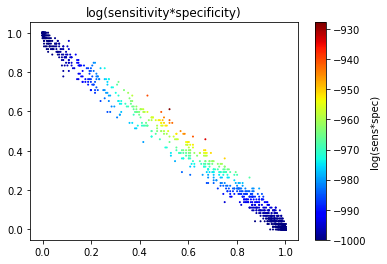

In [90]:
plt.scatter(sensitivity, specificity, s=1, c=-1e3*(1-10**ag_np.log(sensitivity*specificity)), marker=None, cmap='jet', norm=None,
            vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None)
plt.colorbar(label='log(sens*spec)')
#plt.clim([-30,0])
plt.title('log(sensitivity*specificity)')

In [91]:
yhat = ag_np.reshape(predict_with_bnn(x_train_N, bnn_samples[-1], step=True), [num_trials,1])
hits = ag_np.sum(yhat[y_train_N==1])
misses = ag_np.sum(1-yhat[y_train_N==1])
corrRejs = ag_np.sum(1-yhat[y_train_N==0])
FAs = ag_np.sum(yhat[y_train_N==0])
trainAcc = ag_np.sum(yhat==y_train_N)/num_trials
print(hits, misses, corrRejs, FAs, trainAcc)

skm.confusion_matrix(y_train_N, yhat, labels=[1,0])

176 0 0 72 0.7096774193548387


array([[176,   0],
       [ 72,   0]])

# Problem 2a

**STATEMENT**: Plot of the Monte-Carlo-estimated optimization objective $\mathcal{L}$ vs. iteration, for each of your runs. This should be one plot with multiple lines. Write a clear caption indicating number of Monte Carlo samples and step-size used, as well as 1-2 sentences summarizing your strategy for selecting these values.

**NOTE**: This is a bit overkill, the desired plot is the left-most panel. The other plots are good additional diagnostics.

Text(0.5, 0, 'iter')

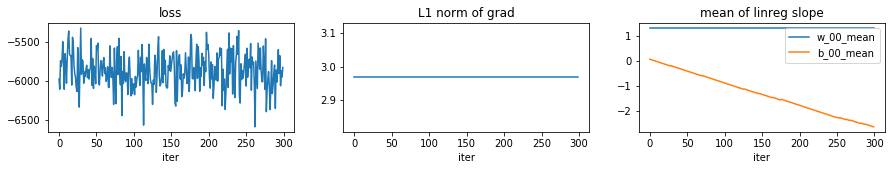

In [92]:
_, subplot_grid = plt.subplots(
    nrows=1, ncols=3, figsize=(15, 2),
    sharex=True, sharey=False, squeeze=False)

for info in info_by_chain:
    subplot_grid[0,0].plot(info['iter'], info['loss'])
subplot_grid[0,0].set_title('loss')
subplot_grid[0,0].set_xlabel('iter')

for info in info_by_chain:
    subplot_grid[0,1].plot(info['iter'], info['grad_L1_norm'])
subplot_grid[0,1].set_title('L1 norm of grad');
subplot_grid[0,1].set_xlabel('iter')

for info in info_by_chain:
    subplot_grid[0,2].plot(info['iter'], info['w_00_mean'], info['b_00_mean'])
    subplot_grid[0,2].legend(['w_00_mean','b_00_mean'])
subplot_grid[0,2].set_title('mean of linreg slope')
subplot_grid[0,2].set_xlabel('iter')

In [93]:
info['grad_L1_norm'][-1]

2.9673590504451037

**CAPTION**: Trace plots for BBVI using 300 MC samples and step_size 0.00002. 300 MC samples was chosen because 100 gave a little too much error in preliminary experiments, while any more than 300 was just too expensive. Step size was chosen after trying a few values in the range (1e-5, 1e-2).

Note that one run (#4 of 5) seems to deliver very different learned parameters.

# Zoom in on loss traces

**NOTE**: This is some bonus additional diagnostics... compute average loss of last 1000 iters.

**PUNCHLINE**: Do all 5 runs seem to converge to the same loss? NO!

In [ ]:
_, subplot_grid = plt.subplots(
    nrows=1, ncols=n_chains, figsize=(15, 2),
    sharex=True, sharey=True, squeeze=False)

for ii, info in enumerate(info_by_chain):
    subplot_grid[0,ii].plot(info['iter'], info['loss'])
    subplot_grid[0,ii].set_title('run %d/%d: avg. loss=% 5.1f' % (
        ii+1, n_chains, ag_np.mean(info['loss'][-1000:])))

#subplot_grid[0,0].set_xlim(n_bbvi_iters_per_chain-5000, n_bbvi_iters_per_chain)
#subplot_grid[0,0].set_ylim(100, 500);

# Problem 2b

**STATEMENT**: Make a 1x3 grid of plots, each one showing sampled function values 𝑓 from each of your independent runs. Show 10 samples per plot.

In [94]:
n_samples = 10
bnn_samples = sample_bnn_params_from_q(
        q_params_by_chain[-1], n_samples=n_samples, prng=ag_np.random.RandomState(1000))
f_SG = ag_np.zeros((n_samples, x_train_N.shape[0]))
    
for s, bnn_sample in enumerate(bnn_samples):
    f_SG[s] = predict_with_bnn(x_train_N, bnn_sample)
    
f_SG[-1]

ValueError: could not broadcast input array from shape (248,1) into shape (248)

In [ ]:
f_SG[-2]

In [ ]:
fig_h, axis_grid = plt.subplots(
    nrows=1, ncols=n_chains,
    figsize=(10*n_chains, 10),
    sharex=True, sharey=True, squeeze=False)

n_samples = 1

for chain_id in range(n_chains):
    
    bnn_samples = sample_bnn_params_from_q(
        q_params_by_chain[chain_id], n_samples=n_samples, prng=ag_np.random.RandomState(1000 + chain_id))
    
    f_SG = ag_np.zeros((n_samples, x_train_N.shape[0]))
    
    for s, bnn_sample in enumerate(bnn_samples):
        f_SG[s] = predict_with_bnn(x_train_N, bnn_sample)

    plot_f_samples_at_x_grid(ag_np.arange(x_train_N.shape[0]), f_SG, axis_handle=axis_grid[0, chain_id])
    axis_grid[0, chain_id].plot(x_train_N, y_train_N, 'k.', markersize=10)

    axis_grid[0, chain_id].set_title('run %d/%d: avg. loss=% 5.1f' % (
        chain_id+1, n_chains, ag_np.mean(info_by_chain[chain_id]['loss'][-1000:])))

    axis_grid[0, chain_id].set_ylim([-8, 8])


# Problem 2c

**STATEMENT**: Make a 1x3 grid of plots, each one showing a filled posterior plot of the posterior (mean +/- 2 std dev) from each of your independent runs. Show one plot per run/chain.

In [ ]:
fig_h, axis_grid = plt.subplots(
    nrows=1, ncols=n_chains,
    figsize=(3*n_chains, 3),
    sharex=True, sharey=True, squeeze=False)

x_grid_G = ag_np.linspace(-20, 20, 201)
n_samples = 1000

for chain_id in range(n_chains):
    
    bnn_samples = sample_bnn_params_from_q(
        q_params_by_chain[chain_id], n_samples=n_samples, prng=ag_np.random.RandomState(1000 + chain_id))
    
    f_SG = ag_np.zeros((n_samples, x_grid_G.size))
    for s, bnn_sample in enumerate(bnn_samples):
        f_SG[s] = predict_with_bnn(x_grid_G, bnn_sample)

    plot_empirical_mean_with_filled_stddevs_for_f_samples_at_x_grid(
        x_grid_G,
        f_SG,
        axis_handle=axis_grid[0, chain_id])
    axis_grid[0, chain_id].plot(x_train_N, y_train_N, 'k.', markersize=10)
    axis_grid[0, chain_id].set_xlim([-20, 20])
    axis_grid[0, chain_id].set_title('Run %d/%d' % (chain_id+1, n_chains))
    axis_grid[0, chain_id].set_ylim([-8, 8])


# Problem 2d

**STATEMENT:** d. Short answer (1-3 sentences): How does this result compare to the HMC posterior from HW2. What is different? Which one is a better fit? Which method is more reliable?


**SOLUTION**:

HMC seems to offer a *better fit*, and also seems *more reliable* across runs.

Compared to HW2's official posterior interval plot (for reference shown below), we see that the presented BBVI approximate posteriors shown in plot 2c have several shortcomings. Primarily, at $x$ values far from training data, we do not see nearly as wide of the uncertainty intervals that we saw from HMC in HW2.

For instance, compare around x=-10:

* HW2's HMC had an interval between -8 and +1 consistently across all 5 runs
* BBVI here has an interval between -6 and -4 in most runs (#1-3)
* BBVI in run 5 (best run in terms of loss) looks better, but has a worse interval for x=+10

BBVI looks a little too certain, and (worryingly) some of the best performing runs (best in terms of final average loss value, labeled 1-3 above) do not seem to have uncertainty increase as we get further from data.

Regarding reliability (can we get multiple runs to deliver the same solution?), the BBVI seems much less reliable than HMC. The noisy estimates of the gradient required for BBVI's gradient descent are troublesome.

In [ ]:
from IPython.display import Image
Image("HW2_20180911_Problem2_10HiddenTANH_IntervalsFromPosterior_5Chains_xlim15.png")